In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
import xgboost as xgb

from sklearn.metrics import accuracy_score, classification_report, silhouette_score

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [9]:
char_df = pd.read_csv('data/dd_bios_02.csv', encoding='ISO-8859-1')

char_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3447 entries, 0 to 3446
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   timestamp            2447 non-null   object
 1   character_name       3447 non-null   object
 2   character_species    3447 non-null   object
 3   character_class      3447 non-null   object
 4   character_backstory  3343 non-null   object
dtypes: object(5)
memory usage: 134.8+ KB


In [10]:
char_df = char_df.drop(columns=['timestamp'])


In [11]:
char_df.head()

,character_name,character_species,character_class,character_backstory
0,Erryt,Aarakocra,Ranger,"Erryt, a 7 year-old Aarakocra with golden plum..."
1,Katyusha,Aarakocra,Cleric,Real name Erryt\n\nLives in fantasy Soviet Uni...
2,Surkiikri,Aarakocra,Monk,Surkiikri was firstborn of the ruling family o...
3,Azriel,Aasamar,Paladin,He was raised the isles in a family of nobles ...
4,Azophyr,Aasimar,Paladin,Hi... I'm Azophyr. I'm a fallen aasimar devoti...


In [12]:
char_df = char_df.dropna()

In [13]:
char_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3343 entries, 0 to 3446
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   character_name       3343 non-null   object
 1   character_species    3343 non-null   object
 2   character_class      3343 non-null   object
 3   character_backstory  3343 non-null   object
dtypes: object(4)
memory usage: 130.6+ KB


In [14]:
char_df.character_species.unique()

array(['Aarakocra', 'Aasamar', 'Aasimar', 'aasimar', 'Alien', 'Android',
       'Anthropomorphic Cockroach', 'Aquatic Half-Elf', 'Beeforged',
       'Birali (homebrew, sort of like a cat-folk)',
       'Birali turned back to Human', 'Birdfolk', 'Blue Dragonborn',
       'BugBear', 'Cambion', 'Catfolk', 'Catgirl', 'Celestial',
       'Changeling', 'Copper Dragonborn', 'Dark Elf', 'dark elf',
       'Dark elf', 'Dark Elf/Human', 'Deep Gnome', 'Demon', 'Dragonborn',
       'Drow', 'drow', 'Drow Elf', 'Drow elf', 'Dwarf', 'dwarf',
       'Earth Genasi', 'Eladrin', 'Elan', 'Elf', 'elf', 'Elf (Drow)',
       'Elf (Wood)', 'Fey Corgi', 'Feyblood', 'Fire genasi',
       'Forest gnome', 'Forest Gnome', 'genasi', 'Genasi',
       'Ghostwise Halfling', 'Ghoul Medusa', 'Githyanki', 'Gnoll',
       'Gnome', 'gnome', 'goblin', 'Goblin', 'Goliath', 'goliath',
       'Grey Elf', 'Hafling', 'Half Cat folk/ Half Elf', 'Half drow',
       "Half dwarf, half elf/orc (don't question it)", 'Half Elf',
      

In [15]:
# Convert all values in the 'character_species' and 'character_class' column to lowercase
char_df['character_species'] = char_df['character_species'].str.lower()
char_df['character_class'] = char_df['character_class'].str.lower()
char_df['character_name'] = char_df['character_name'].str.lower()
char_df['character_backstory'] = char_df['character_backstory'].str.lower()



# Verify the change
char_df['character_species'].unique()

array(['aarakocra', 'aasamar', 'aasimar', 'alien', 'android',
       'anthropomorphic cockroach', 'aquatic half-elf', 'beeforged',
       'birali (homebrew, sort of like a cat-folk)',
       'birali turned back to human', 'birdfolk', 'blue dragonborn',
       'bugbear', 'cambion', 'catfolk', 'catgirl', 'celestial',
       'changeling', 'copper dragonborn', 'dark elf', 'dark elf/human',
       'deep gnome', 'demon', 'dragonborn', 'drow', 'drow elf', 'dwarf',
       'earth genasi', 'eladrin', 'elan', 'elf', 'elf (drow)',
       'elf (wood)', 'fey corgi', 'feyblood', 'fire genasi',
       'forest gnome', 'genasi', 'ghostwise halfling', 'ghoul medusa',
       'githyanki', 'gnoll', 'gnome', 'goblin', 'goliath', 'grey elf',
       'hafling', 'half cat folk/ half elf', 'half drow',
       "half dwarf, half elf/orc (don't question it)", 'half elf',
       'half orc', 'half-dragon half-elf', 'half-drow',
       'half-dwarf / half-ogre', 'half-elf', 'half-elf (drow)',
       'half-orc', 'half-or

In [16]:
def replace_string_in_column(df, column, old_string, new_string):
    """
    Replaces occurrences of a specific string in a column with a new string.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the column.
    column (str): The column name where the replacement should happen.
    old_string (str): The string to search for.
    new_string (str): The string to replace the old one with.

    Returns:
    pd.DataFrame: The DataFrame with the updated column.
    """
    df.loc[df[column].str.contains(old_string, case=False, na=False), column] = new_string
    return df

In [17]:
# We can clean up some glaring issues. There are still a lot of homebrew species, we will leave them as is. 

char_df = replace_string_in_column(char_df, 'character_species', 'aasamar', 'aasimar')
char_df = replace_string_in_column(char_df, 'character_species', 'half elf', 'half-elf')
char_df = replace_string_in_column(char_df, 'character_species', 'half drow', 'half-elf (drow)')
char_df = replace_string_in_column(char_df, 'character_species', 'half-drow', 'half-elf (drow)')
char_df = replace_string_in_column(char_df, 'character_species', 'half-ord', 'half-orc')
char_df = replace_string_in_column(char_df, 'character_species', 'drow', 'elf (drow)')
char_df = replace_string_in_column(char_df, 'character_species', 'drow elf', 'elf (drow)')
char_df = replace_string_in_column(char_df, 'character_species', 'humam', 'human')


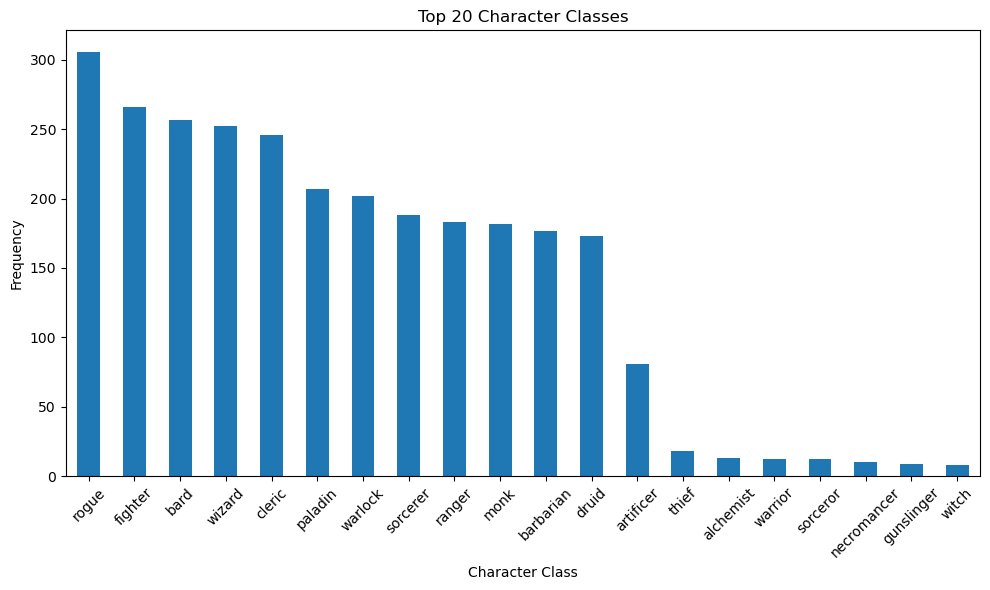

In [18]:
top_20_classes = char_df.character_class.value_counts().head(20)

# Create the plot
plt.figure(figsize=(10,6))
top_20_classes.plot(kind='bar')
plt.title('Top 20 Character Classes')
plt.xlabel('Character Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

This is a solid representation of the 5ed classes available, and a good number of other types of classes that make up this dataset. 

Let's start cleaning up the rest of the text to get ready for tokenization

In [19]:
# !pip install nltk

In [20]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

# Make sure you have stopwords and lemmatizer from NLTK
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

basic_token_pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(basic_token_pattern)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dmm46\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dmm46\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
# Preprocessing function: tokenization, lemmatization, and stopword removal
def preprocess_backstory(text):
    tokens = tokenizer.tokenize(text.lower())  # Lowercase and tokenize
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize each token
    return ' '.join([word for word in lemmatized_tokens if word not in stop_words])  # Remove stopwords

In [22]:
# Apply preprocessing to the character_backstory column
char_df['cleaned_backstory'] = char_df['character_backstory'].apply(preprocess_backstory)

In [23]:
# Vectorize the cleaned backstories using TF-IDF
vectorizer = TfidfVectorizer()
vectored_backstory = vectorizer.fit_transform(char_df['cleaned_backstory'])

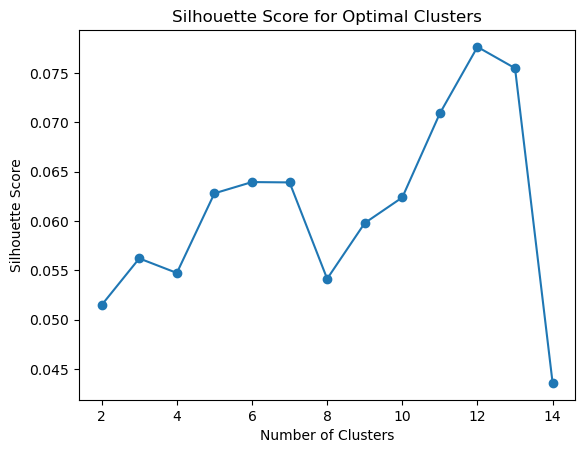

In [24]:
# Evaluate the Silhouette Score for different numbers of clusters
silhouette_scores = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(vectored_backstory)
    silhouette_scores.append(silhouette_score(vectored_backstory, labels))

# Plot the Silhouette Score
plt.plot(range(2, 15), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Clusters')
plt.show()

In [25]:
silhouette_scores

[0.051481727156470786,
 0.056206860116475583,
 0.05473199036635365,
 0.06281100447219017,
 0.06395495044539366,
 0.06392009659897392,
 0.05413950140262824,
 0.059794169839444314,
 0.062395224909765415,
 0.0709281867179225,
 0.07766889826669975,
 0.07550930358528413,
 0.04357267216652583]

In [26]:
max_value = max(silhouette_scores)
index_of_max = silhouette_scores.index(max_value)
index_of_max

10

Choose the number of clusters that yields the highest silhouette score.

In [27]:


# Use K-Means clustering to find themes
num_clusters = index_of_max+2  # Based on the silohuette score above. 
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(vectored_backstory)

# Add the cluster labels as the theme category
char_df['backstory_cluster'] = kmeans.fit_predict(vectored_backstory)



In [28]:
# View the DataFrame with the new cluster labels
print(char_df[['character_name', 'character_species', 'character_class', 'backstory_cluster']])

           character_name character_species character_class  backstory_cluster
0                   erryt         aarakocra          ranger                  6
1                katyusha         aarakocra          cleric                  6
2               surkiikri         aarakocra            monk                  6
3                  azriel           aasimar         paladin                  2
4                 azophyr           aasimar         paladin                  6
...                   ...               ...             ...                ...
3442    seren oakenshield          plasmoid        sorcerer                  1
3443               lirael               elf            monk                  1
3444               aelric             owlin         fighter                  1
3445      bruni firebrand             dwarf          wizard                  9
3446  aelric shadowdancer           bugbear       barbarian                  1

[3343 rows x 4 columns]


In [29]:
char_df

,character_name,character_species,character_class,character_backstory,cleaned_backstory,backstory_cluster
0,erryt,aarakocra,ranger,"erryt, a 7 year-old aarakocra with golden plum...",erryt year old aarakocra golden plumage crest ...,6
1,katyusha,aarakocra,cleric,real name erryt\n\nlives in fantasy soviet uni...,real name erryt life fantasy soviet union vale...,6
2,surkiikri,aarakocra,monk,surkiikri was firstborn of the ruling family o...,surkiikri wa firstborn ruling family mistcliff...,6
3,azriel,aasimar,paladin,he was raised the isles in a family of nobles ...,wa raised isle family noble close tie god ange...,2
4,azophyr,aasimar,paladin,hi... i'm azophyr. i'm a fallen aasimar devoti...,hi azophyr fallen aasimar devotion paladin enc...,6
...,...,...,...,...,...,...
3442,seren oakenshield,plasmoid,sorcerer,"cora is a plasmoid sorcerer, known for their u...",cora plasmoid sorcerer known unmatched skill b...,1
3443,lirael,elf,monk,"lirael stormhand is a elf monk, known for thei...",lirael stormhand elf monk known unmatched skil...,1
3444,aelric,owlin,fighter,"drake shadowdancer is a owlin fighter, known f...",drake shadowdancer owlin fighter known unmatch...,1
3445,bruni firebrand,dwarf,wizard,"durin spent their youth in dusty libraries, po...",durin spent youth dusty library poring ancient...,9


In [30]:
from collections import Counter

# Function to get word frequency for a cluster
def get_word_frequency(cluster_num):
    # Filter rows belonging to the specified cluster
    cluster_text = char_df[char_df['backstory_cluster'] == cluster_num]['cleaned_backstory']
    
    # Join all backstories in the cluster into a single string
    all_words = ' '.join(cluster_text).split()
    
    # Use Counter to get word frequencies
    word_freq = Counter(all_words)
    
    # Get the top 10 most common words in the cluster
    return word_freq.most_common(10)

# Loop over each cluster and get word frequencies
n_clusters = char_df['backstory_cluster'].nunique()  # Find the number of unique clusters

for cluster_num in range(n_clusters):
    print(f"\nCluster {cluster_num} - Top Words:")
    top_words = get_word_frequency(cluster_num)
    for word, freq in top_words:
        print(f"{word}: {freq}")


Cluster 0 - Top Words:
wa: 123
church: 46
training: 32
home: 24
year: 22
one: 21
world: 20
paladin: 19
life: 18
way: 18

Cluster 1 - Top Words:
yet: 1214
known: 607
unmatched: 607
skill: 607
battle: 607
unwavering: 607
loyalty: 607
comrade: 607
journeyed: 607
far: 607

Cluster 2 - Top Words:
family: 441
wa: 364
ha: 106
life: 100
one: 99
year: 94
world: 74
age: 74
parent: 73
time: 71

Cluster 3 - Top Words:
power: 152
bryn: 88
never: 76
intended: 76
make: 76
pact: 76
force: 76
beyond: 76
world: 76
desperation: 76

Cluster 4 - Top Words:
noble: 82
wa: 59
family: 31
ha: 19
power: 19
world: 12
pieri: 12
city: 11
life: 10
way: 10

Cluster 5 - Top Words:
ha: 79
like: 77
one: 69
wa: 56
life: 51
people: 49
well: 37
day: 36
world: 36
find: 35

Cluster 6 - Top Words:
wa: 940
ha: 425
one: 291
world: 234
life: 228
magic: 209
year: 207
power: 181
god: 179
way: 166

Cluster 7 - Top Words:
wa: 206
temple: 118
left: 28
one: 26
found: 25
year: 24
soldier: 24
army: 22
life: 22
raised: 21

Cluster 8 - T

______

To begin predicting on these clusters, we will need to turn the features into numerical data

_______

In [31]:
# Step 1: Encode categorical features (name, species, class) into numeric form
le_name = LabelEncoder()
le_species = LabelEncoder()
le_class = LabelEncoder()

char_df['encoded_name'] = le_name.fit_transform(char_df['character_name'])
char_df['encoded_species'] = le_species.fit_transform(char_df['character_species'])
char_df['encoded_class'] = le_class.fit_transform(char_df['character_class'])

In [32]:
# Features and target
X = char_df[['encoded_species', 'encoded_class']]
y = char_df['backstory_cluster']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
X

,encoded_species,encoded_class
0,9,254
1,9,78
2,9,190
3,10,225
4,10,225
...,...,...
3442,228,313
3443,82,190
3444,218,124
3445,76,392


____

## Let's do a shotgun approach and run these features/target through a bunch of models

____

In [34]:
# Define the models to try
models = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Support Vector Classifier': SVC(),
    'Naive Bayes': MultinomialNB()  # Naive Bayes often works well with categorical data
}

In [35]:
# Step 4: Train and evaluate each model
for model_name, model in models.items():
    if model_name == 'Naive Bayes':
        # Use MinMaxScaler for MultinomialNB
        pipeline = Pipeline([
            ('scaler', MinMaxScaler()),  # Use MinMaxScaler for Naive Bayes to avoid negative values
            ('classifier', model)
        ])
    else:
        # Use StandardScaler for the other models
        pipeline = Pipeline([
            ('scaler', StandardScaler()),  # Use StandardScaler for other models
            ('classifier', model)
        ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = pipeline.predict(X_test)
    
    # Classification report
    print(f"Results for {model_name}:")
    print(classification_report(y_test, y_pred, zero_division=0))

Results for Random Forest:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.60      0.69      0.65       108
           2       0.26      0.12      0.16        58
           3       0.73      0.85      0.79        13
           4       0.00      0.00      0.00         4
           5       0.12      0.06      0.08        35
           6       0.41      0.55      0.47       221
           7       0.00      0.00      0.00        11
           8       0.62      0.81      0.70        16
           9       0.74      0.65      0.69        26
          10       0.22      0.18      0.20       145
          11       0.67      0.71      0.69        14

    accuracy                           0.42       669
   macro avg       0.37      0.39      0.37       669
weighted avg       0.38      0.42      0.40       669

Results for Logistic Regression:
              precision    recall  f1-score   support

           0      

____

Random Forest turned out the best initial accuracy, a very low 42%. Let's try and improve on that.

_____

In [36]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

print(f"Best Parameters: {grid_search.best_params_}")
print(classification_report(y_test, y_pred))

Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       0.09      0.17      0.12        18
           1       0.57      0.82      0.67       108
           2       0.20      0.33      0.25        58
           3       0.39      0.92      0.55        13
           4       0.04      0.50      0.07         4
           5       0.06      0.06      0.06        35
           6       0.48      0.16      0.24       221
           7       0.04      0.18      0.07        11
           8       0.64      0.88      0.74        16
           9       0.56      0.85      0.68        26
          10       0.24      0.11      0.15       145
          11       0.50      0.79      0.61        14

    accuracy                           0.34       669
   macro avg       0.32      0.48      0.35       669
weighted avg       0.38      0.34      0.32       669



____

grid search made it worse!

____

In [37]:
model = RandomForestClassifier(class_weight='balanced', random_state=42)
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"Mean accuracy: {scores.mean()}")

Mean accuracy: 0.3404155813932673


Using the voting classifier, we can use mulitple models together. 

In [38]:
from sklearn.ensemble import VotingClassifier

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Apply scaling
    ('classifier', LogisticRegression(solver='saga', max_iter=500, random_state=42))
])

model1 = RandomForestClassifier(random_state=42)
model2 = LogisticRegression(max_iter=500, random_state=42)
model3 = SVC(probability=True, random_state=42)

ensemble_model = VotingClassifier(estimators=[
    ('rf', model1), ('lr', pipeline), ('svc', model3)],
    voting='soft')

ensemble_model.fit(X_train, y_train)
y_pred = ensemble_model.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.57      0.68      0.62       108
           2       0.40      0.03      0.06        58
           3       0.73      0.85      0.79        13
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00        35
           6       0.41      0.74      0.53       221
           7       0.00      0.00      0.00        11
           8       0.83      0.62      0.71        16
           9       0.79      0.58      0.67        26
          10       0.23      0.12      0.16       145
          11       0.91      0.71      0.80        14

    accuracy                           0.45       669
   macro avg       0.41      0.36      0.36       669
weighted avg       0.40      0.45      0.39       669



___

We are up to 45%, not really amazing at all

____